# File parsing

Group project for the 2019 Data Science Workshop at the University of California, Berkeley.

The project is the Google Analytics Customer Revenue Prediction competition on Kaggle: https://www.kaggle.com/c/ga-customer-revenue-prediction

Group members:

* Andy Vargas (mentor)
* Yuem Park
* Marvin Pohl
* Michael Yeh

In [568]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import os
import ast
from pandas.io.json import json_normalize
import pandas_profiling as pp
import math
import datetime

Load data:

Note that the data files are too large to upload to GitHub - instead, the directory `./data/` has been added to the .gitignore, which should contain the following files on your local machine, all downloaded from the Kaggle competition website:

* sample_submission_v2.csv
* test_v2.csv
* train_v2.csv

Some of the columns are in JSON format - the following function (taken from [here](https://www.kaggle.com/sudalairajkumar/simple-exploration-baseline-ga-customer-revenue)) flattens the JSON columns, such that we end up with a more typical data table, where each column has a single feature in it:

In [ ]:
def load_df(csv_path=None, nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource'] # columns of the dataframe that can readily be converted
    JSON_COLUMNS2 = ['customDimensions','device', 'geoNetwork', 'totals', 'trafficSource'] # columns of the dataframe that need to be tweaked
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, # convert JSON_COLUMNS to json format
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
    
    for row in list(range(nrows)): # fill empty elements in column 'customDimensions' and 
        if df['customDimensions'][row] == '[]':
            df['customDimensions'][row] = "{'index':'','value':''}"
    
    df['customDimensions'] = df['customDimensions'].str.replace("[", '') # drop square brackets in column 'customDimensions'
    df['customDimensions'] = df['customDimensions'].str.replace("]", '')
    df['customDimensions'] = df['customDimensions'].str.replace("'", "\"")
    
    for row in list(range(nrows)): # convert strings in 'customDimensions' to dict
        df['customDimensions'][row] = json.loads(df['customDimensions'][row])
        
    for column in JSON_COLUMNS2: # distribute the dicts to separate columns of the dataframe
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    
    return df

In [ ]:
def hits_converter(data):
    return json.loads(json.dumps(ast.literal_eval(data)))

def customDimensions_converter(data):
    if data == '[]':
        return {}
    else:
        return hits_converter(data)[0]

def load_df(csv_path='data/train_v2.csv', nrows=None):
    
    conv_dict = {'device': json.loads,
                'geoNetwork': json.loads,
                'totals': json.loads,
                'trafficSource': json.loads,
                'hits': hits_converter,
                'customDimensions': customDimensions_converter}
    
    df = pd.read_csv(csv_path, 
                     converters=conv_dict, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
    
    df=df.explode('hits')
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource', 'hits', 'customDimensions']
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
        
    df=df.reset_index()
    return df

Load a small subset of train_v2, defined by `nrows`.

In [3]:
%%time
train_df = load_df('./data/train_v2.csv', nrows=170000) # nrows defines size of subset
train_df.head()

/Users/Marvin/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/Users/Marvin/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


CPU times: user 15min 31s, sys: 7.57 s, total: 15min 38s
Wall time: 15min 37s


,channelGrouping,date,fullVisitorId,hits,socialEngagementType,visitId,visitNumber,visitStartTime,customDimensions.index,customDimensions.value,...,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.referralPath,trafficSource.isTrueDirect,trafficSource.adContent,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.campaignCode
0,Organic Search,20171016,3162355547410993243,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,1508198450,1,1508198450,4,EMEA,...,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Referral,20171016,8934116514970143966,"[{'hitNumber': '1', 'time': '0', 'hour': '10',...",Not Socially Engaged,1508176307,6,1508176307,4,North America,...,not available in demo dataset,/a/google.com/transportation/mtv-services/bike...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Direct,20171016,7992466427990357681,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,1508201613,1,1508201613,4,North America,...,not available in demo dataset,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Organic Search,20171016,9075655783635761930,"[{'hitNumber': '1', 'time': '0', 'hour': '9', ...",Not Socially Engaged,1508169851,1,1508169851,4,EMEA,...,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Organic Search,20171016,6960673291025684308,"[{'hitNumber': '1', 'time': '0', 'hour': '14',...",Not Socially Engaged,1508190552,1,1508190552,4,Central America,...,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Clean up
There seems to be a few columns that are 'not available in demo dataset.' Let's get rid of them, as well as any features that only have a single value (and therefore are not useful for differentiating samples):

In [4]:
NA_cols = []
for col in train_df.columns:
    if train_df[col].nunique()==1: # find columns that have only 1 unique element
        NA_cols.append(col) # create list of these columns 

Drop colums with only a single unique element and the column `hits`:

In [5]:
train_df.drop(NA_cols, axis=1, inplace=True)
train_df.drop('hits', axis=1, inplace=True)

Convert `date` column to time stamps and slice dataframe:

In [26]:
train_df['date'] = pd.to_datetime(train_df['date'], format='%Y%m%d')
train_df.head()

Function to define start date and number of days for train dataframe and test dataframe:

In [363]:
def period1(start_date='2016-11-30', days = 0):
    end_date = (pd.to_datetime(start_date) + pd.DateOffset(days)).strftime("%Y-%m-%d")
    
    df = train_df.loc[(train_df['date'] >= start_date) & (train_df['date'] <= end_date)]
    df=df.reset_index()
    df=df.drop(columns='index')
    
    print('start date =', start_date)
    print('end date =', end_date)
    return df

def period2(start_date='2016-11-30', days = 0, gap = 0):
    end_date = (pd.to_datetime(start_date) + pd.DateOffset(days)).strftime("%Y-%m-%d")
    start_date_period2 = (pd.to_datetime(end_date) + pd.DateOffset(gap)).strftime("%Y-%m-%d")
    end_date_period2 = (pd.to_datetime(start_date_period2) + pd.DateOffset(days)).strftime("%Y-%m-%d")
    
    df = train_df.loc[(train_df['date'] >= start_date_period2) & (train_df['date'] <= end_date_period2)]
    df=df.reset_index()
    df=df.drop(columns='index')
    
    print('start date =', start_date)
    print('end date =', end_date)
    print('start date (target period) =', start_date_period2)
    print('end date (target period) =', end_date_period2)
    return df

In [364]:
period1_df = period1(start_date='2016-08-01', days=168)
period1_df

start date = 2016-08-01
end date = 2017-01-16


,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,customDimensions.index,customDimensions.value,device.browser,device.operatingSystem,...,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.referralPath,trafficSource.adContent,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType
0,Organic Search,2016-09-02,9499785259412240342,1472812272,1,1472812272,4,EMEA,Firefox,Windows,...,(not set),google,organic,(not provided),NaN,NaN,NaN,NaN,NaN,NaN
1,Organic Search,2016-09-02,3696906537737368442,1472856874,1,1472856874,4,South America,Chrome,Windows,...,(not set),google,organic,(not provided),NaN,NaN,NaN,NaN,NaN,NaN
2,Organic Search,2016-09-02,5688512451361930466,1472811524,1,1472811524,4,APAC,Chrome,Linux,...,(not set),google,organic,(not provided),NaN,NaN,NaN,NaN,NaN,NaN
3,Organic Search,2016-09-02,9716453263501147451,1472823508,1,1472823508,4,APAC,Safari,iOS,...,(not set),google,organic,(not provided),NaN,NaN,NaN,NaN,NaN,NaN
4,Organic Search,2016-09-02,5330453591145100432,1472839619,1,1472839619,4,South America,Chrome,Windows,...,(not set),google,organic,(not provided),NaN,NaN,NaN,NaN,NaN,NaN
5,Organic Search,2016-09-02,4904559133238424046,1472872837,1,1472872837,,,Chrome,Macintosh,...,(not set),google,organic,(not provided),NaN,NaN,NaN,NaN,NaN,NaN
6,Organic Search,2016-09-02,0767747510961437997,1472856318,1,1472856318,4,North America,Chrome,Windows,...,(not set),google,organic,(not provided),NaN,NaN,NaN,NaN,NaN,NaN
7,Paid Search,2016-09-02,3979370936323071925,1472851504,1,1472851504,4,North America,Safari,iOS,...,AW - Dynamic Search Ads Whole Site,google,cpc,6qEhsCssdK0z36ri,NaN,NaN,1,Top,Cj0KEQjwxqS-BRDRgPLp0q2t0IUBEiQAgfMXRE1NdtWc6_...,Google Search
8,Organic Search,2016-09-02,4862622267848827616,1472853880,1,1472853880,4,North America,Chrome,Android,...,(not set),google,organic,(not provided),NaN,NaN,NaN,NaN,NaN,NaN
9,Organic Search,2016-09-02,6987021577579660288,1472821960,1,1472821960,,,Safari,iOS,...,(not set),google,organic,(not provided),NaN,NaN,NaN,NaN,NaN,NaN


In [365]:
period2_df = period2(start_date='2016-08-01', days = 168, gap = 62)
period2_df

start date = 2016-08-01
end date = 2017-01-16
start date (target period) = 2017-03-19
end date (target period) = 2017-09-03


,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,customDimensions.index,customDimensions.value,device.browser,device.operatingSystem,...,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.referralPath,trafficSource.adContent,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType
0,Organic Search,2017-06-23,8220376077399595986,1498223351,1,1498223351,4,South America,Chrome,Windows,...,(not set),(direct),(none),NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Organic Search,2017-06-23,1000831944282857356,1498232484,2,1498232484,4,Central America,Chrome,Macintosh,...,(not set),(direct),(none),NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Direct,2017-06-23,7830153712423772213,1498237863,1,1498237863,4,EMEA,Chrome,Macintosh,...,(not set),(direct),(none),NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Direct,2017-06-23,6641049248090905193,1498223514,1,1498223514,4,EMEA,Safari,iOS,...,(not set),(direct),(none),NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Organic Search,2017-06-23,9993372776950522771,1498218717,1,1498218717,4,North America,Safari,Macintosh,...,(not set),(direct),(none),NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Organic Search,2017-06-23,0022058950177176262,1498203093,1,1498203093,4,APAC,Chrome,Windows,...,(not set),(direct),(none),NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Direct,2017-06-23,768615038025787921,1498264736,1,1498264736,,,Safari,iOS,...,(not set),(direct),(none),NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Direct,2017-06-23,2634402397189541673,1498273878,1,1498273878,4,APAC,Chrome,Macintosh,...,(not set),(direct),(none),NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Organic Search,2017-06-23,3916952552553134238,1498207821,1,1498207821,4,EMEA,Safari,iOS,...,(not set),(direct),(none),NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Organic Search,2017-06-23,3074021932725126293,1498242274,3,1498242274,4,North America,Chrome,Macintosh,...,(not set),(direct),(none),NaN,NaN,NaN,NaN,NaN,NaN,NaN


Select all visitors that appear in both time periods:

In [368]:
compare = []
for element in period2_df.index.values.tolist():
    if period2_df['fullVisitorId'][element] in period1_df['fullVisitorId'].to_list():
        compare.append(element)

period2_returnedVisitors = period2_df.take(compare)
period2_returnedVisitors

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,customDimensions.index,customDimensions.value,device.browser,device.operatingSystem,...,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.referralPath,trafficSource.adContent,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType
72,Organic Search,2017-06-23,744305029202092676,1498244568,2,1498244568,4,EMEA,Safari,Macintosh,...,(not set),(direct),(none),NaN,NaN,NaN,NaN,NaN,NaN,NaN
375,Referral,2017-06-23,344658309918574688,1498231006,50,1498231006,4,North America,Chrome,Windows,...,(not set),(direct),(none),NaN,/,NaN,NaN,NaN,NaN,NaN
402,Direct,2017-06-23,4742180546650265795,1498232495,29,1498232495,,,Firefox,Linux,...,(not set),(direct),(none),NaN,NaN,NaN,NaN,NaN,NaN,NaN
407,Direct,2017-06-23,7282998257608986241,1498217761,47,1498217761,4,APAC,Internet Explorer,Windows,...,(not set),(direct),(none),NaN,NaN,NaN,NaN,NaN,NaN,NaN
487,Direct,2017-06-23,4163967138563839128,1498242105,24,1498242105,4,North America,Chrome,Windows,...,(not set),(direct),(none),NaN,NaN,NaN,NaN,NaN,NaN,NaN
557,Direct,2017-06-23,4386324166188241612,1498247057,2,1498247057,4,North America,Chrome,Macintosh,...,(not set),(direct),(none),NaN,NaN,NaN,NaN,NaN,NaN,NaN
711,Organic Search,2017-06-23,4038076683036146727,1498261199,140,1498261199,4,North America,Chrome,Macintosh,...,(not set),(direct),(none),NaN,NaN,NaN,NaN,NaN,NaN,NaN
1031,Referral,2017-06-23,3379623428571018509,1498228136,7,1498228136,4,North America,Chrome,Macintosh,...,(not set),(direct),(none),NaN,/,NaN,NaN,NaN,NaN,NaN
1104,Referral,2017-06-23,6588500311054802771,1498205791,74,1498205791,4,EMEA,Chrome,Macintosh,...,(not set),analytics.google.com,referral,NaN,/analytics/web/,NaN,NaN,NaN,NaN,NaN
1141,Direct,2017-06-23,4386324166188241612,1498222405,1,1498222405,4,North America,Chrome,Macintosh,...,(not set),(direct),(none),NaN,NaN,NaN,NaN,NaN,NaN,NaN


Select visitors that actually bought something in `period1`:

In [492]:
period1_customers = period1_df.dropna(subset=['totals.transactionRevenue']).reset_index().drop(columns='index')
period1_customers

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,customDimensions.index,customDimensions.value,device.browser,device.operatingSystem,...,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.referralPath,trafficSource.adContent,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType
0,Direct,2016-09-02,6194193421514403509,1472843572,1,1472843572,4,North America,Chrome,Linux,...,(not set),(direct),(none),NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Organic Search,2016-09-02,5327166854580374902,1472844906,3,1472844906,4,North America,Chrome,Macintosh,...,(not set),google,organic,(not provided),NaN,NaN,NaN,NaN,NaN,NaN
2,Referral,2016-09-02,8885051388942907862,1472827393,7,1472827393,4,North America,Chrome,Linux,...,(not set),(direct),(none),NaN,/,NaN,NaN,NaN,NaN,NaN
3,Referral,2016-09-02,0185467632009737931,1472846398,6,1472846398,4,North America,Chrome,Windows,...,(not set),(direct),(none),NaN,/,NaN,NaN,NaN,NaN,NaN
4,Referral,2016-09-02,3244885836845029978,1472824817,4,1472824817,4,North America,Chrome,Macintosh,...,(not set),(direct),(none),NaN,/,NaN,NaN,NaN,NaN,NaN
5,Referral,2016-09-02,3351538799616866750,1472855945,2,1472855945,4,North America,Chrome,Linux,...,(not set),(direct),(none),NaN,/,NaN,NaN,NaN,NaN,NaN
6,Direct,2016-09-02,1776658355119092313,1472861525,1,1472861525,4,North America,Safari,Macintosh,...,(not set),(direct),(none),NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Referral,2016-09-02,770431600902969839,1472836071,13,1472836071,4,North America,Chrome,Linux,...,(not set),(direct),(none),NaN,/,NaN,NaN,NaN,NaN,NaN
8,Referral,2016-09-02,6664733704830724714,1472853995,7,1472853995,4,North America,Chrome,Chrome OS,...,(not set),sites.google.com,referral,NaN,/a/google.com/google-merchandise-store/home/on...,NaN,NaN,NaN,NaN,NaN
9,Organic Search,2016-09-02,7147112211830167925,1472853332,1,1472853332,4,North America,Chrome,Android,...,(not set),google,organic,(not provided),NaN,NaN,NaN,NaN,NaN,NaN


Select visitors that appeared in `period1` and actually bought something in `period2`:

In [489]:
period2_returnedCustomers = period2_returnedVisitors.dropna(subset=['totals.transactionRevenue']).reset_index().drop(columns='index')
period2_returnedCustomers

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,customDimensions.index,customDimensions.value,device.browser,device.operatingSystem,...,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.referralPath,trafficSource.adContent,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType
0,Organic Search,2017-05-01,3287424336851494398,1493658821,31,1493658821,4,North America,Chrome,Chrome OS,...,(not set),google,organic,(not provided),NaN,NaN,NaN,NaN,NaN,NaN
1,Direct,2017-05-01,6002089299065068862,1493663214,23,1493663214,4,North America,Chrome,Macintosh,...,(not set),(direct),(none),NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Direct,2017-05-01,7813149961404844386,1493670951,130,1493670951,4,North America,Chrome,Windows,...,(not set),(direct),(none),NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Organic Search,2017-06-11,1111470101899387454,1497220493,1,1497220493,4,North America,Chrome,iOS,...,(not set),(direct),(none),NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Display,2017-06-30,1957458976293878100,1498830593,315,1498830593,4,North America,Firefox,Windows,...,(not set),dfa,cpm,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Referral,2017-05-19,8820042908642083525,1495242947,5,1495242947,4,North America,Chrome,Macintosh,...,(not set),(direct),(none),NaN,/,NaN,NaN,NaN,NaN,NaN
6,Referral,2017-05-29,4458329221243726234,1496087028,22,1496087028,4,North America,Chrome,Chrome OS,...,(not set),(direct),(none),NaN,/,NaN,NaN,NaN,NaN,NaN
7,Referral,2017-05-15,374253765923087294,1494882269,6,1494882269,4,North America,Chrome,Windows,...,(not set),(direct),(none),NaN,/,NaN,NaN,NaN,NaN,NaN
8,Paid Search,2017-04-20,3921649958751416379,1492703209,12,1492703209,4,North America,Chrome,Chrome OS,...,AW - Accessories,google,cpc,Google Merchandise,NaN,Google Merchandise Collection,1,Top,CjwKCAjwuOHHBRBmEiwAlEMW0B4j09Ol1dHOsKhSIJYpaA...,Google Search
9,Direct,2017-08-01,7311242886083854158,1501623886,28,1501623886,4,North America,Chrome,Chrome OS,...,(not set),(direct),(none),NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [498]:
compare = []
for visitor in period2_returnedCustomers.index.values.tolist():
    if period2_returnedCustomers['fullVisitorId'][visitor] in period1_customers['fullVisitorId'].to_list():
        compare.append(visitor)

period12_customers = period2_returnedCustomers.take(compare)
period12_customers

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,customDimensions.index,customDimensions.value,device.browser,device.operatingSystem,...,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.referralPath,trafficSource.adContent,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType
2,Direct,2017-05-01,7813149961404844386,1493670951,130,1493670951,4,North America,Chrome,Windows,...,(not set),(direct),(none),NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Organic Search,2017-06-11,1111470101899387454,1497220493,1,1497220493,4,North America,Chrome,iOS,...,(not set),(direct),(none),NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Direct,2017-08-01,7311242886083854158,1501623886,28,1501623886,4,North America,Chrome,Chrome OS,...,(not set),(direct),(none),NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,Organic Search,2017-08-19,8197879643797712877,1503196517,46,1503196517,4,North America,Chrome,Chrome OS,...,(not set),google,organic,(not provided),NaN,NaN,NaN,NaN,NaN,NaN


- Only 12 visitors that appeared in period 1 bought something in period 2
- Only 4 visitors bough something in period 1 and period 2

Tasks: 
- Label all visitors in `period1_df` to differentiate between 'returning customers' and 'non-returning customers'. This is the prediction value for the ML model.

- Reduce features (columns).

# Exploratory data analysis

Create pandas_profiling report:

In [6]:
pp.ProfileReport(train_df).to_file('profile_report.html')

Find features that corelate with returning customers:

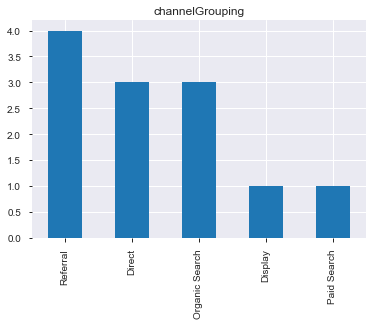

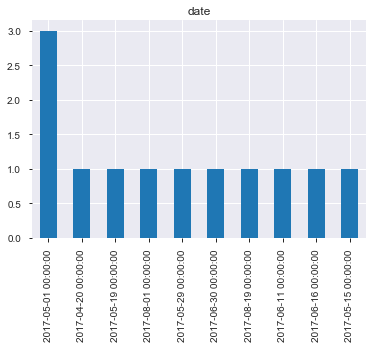

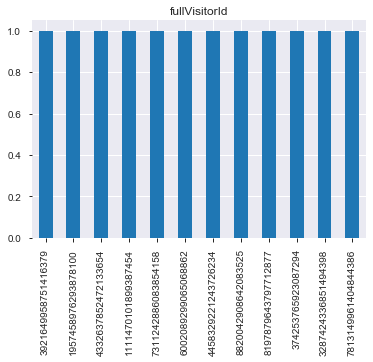

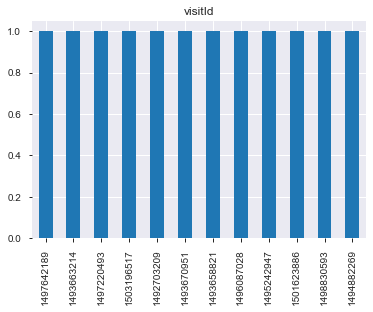

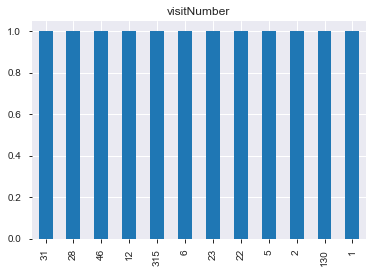

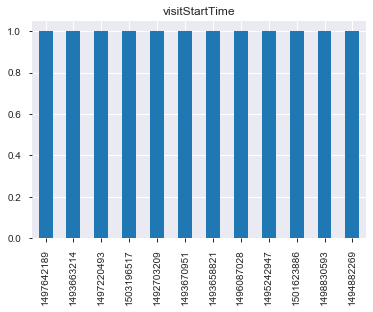

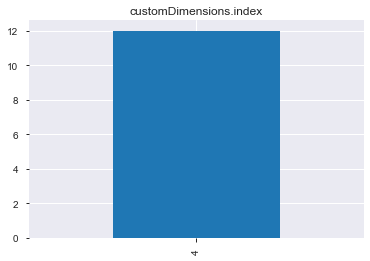

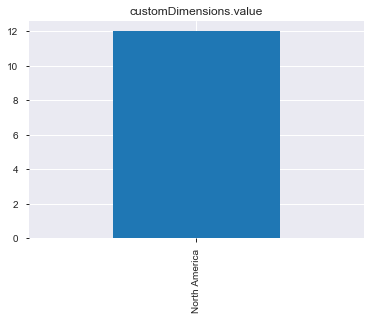

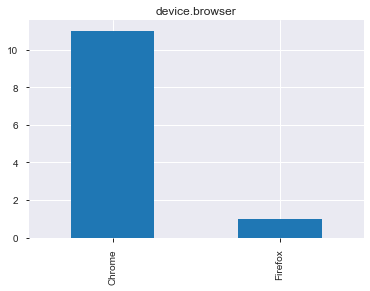

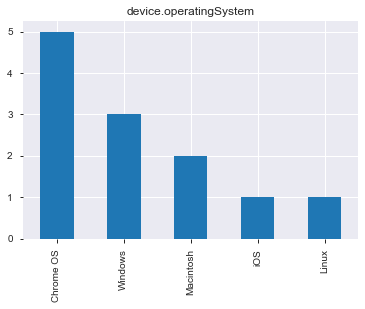

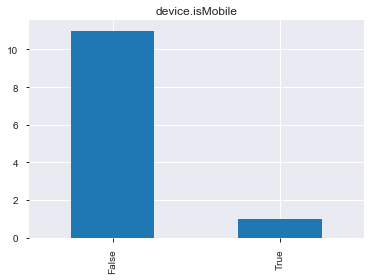

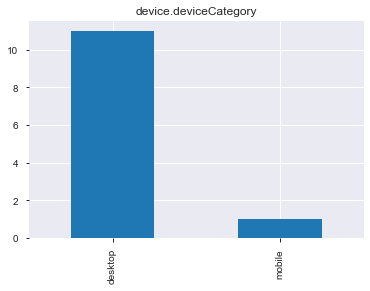

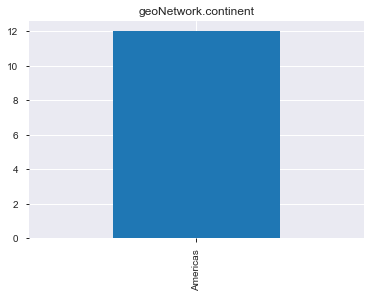

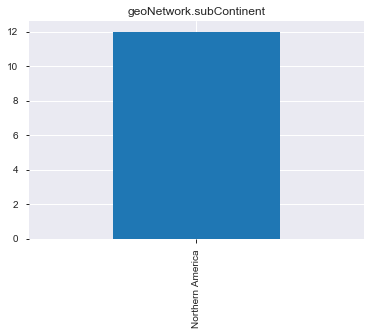

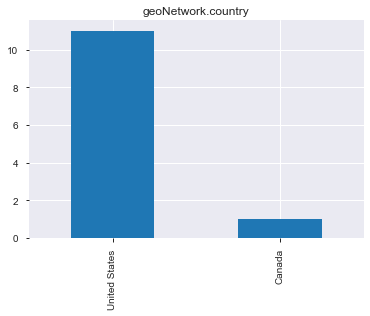

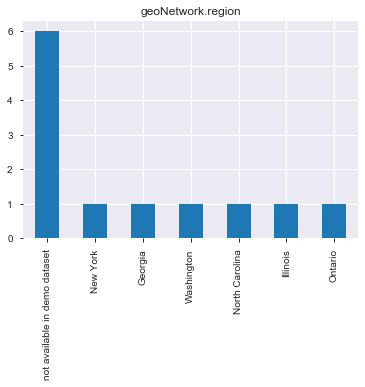

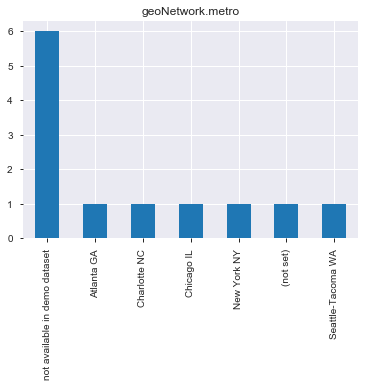

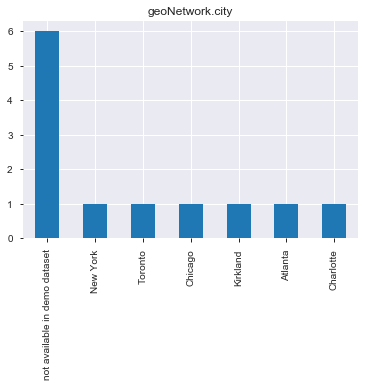

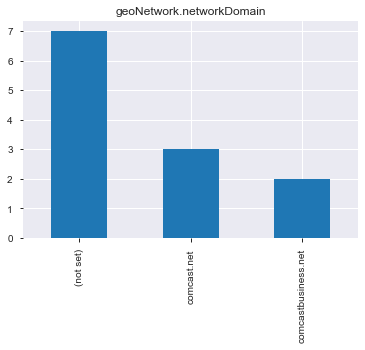

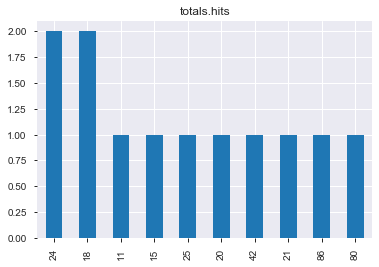

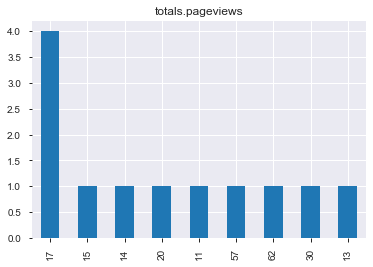

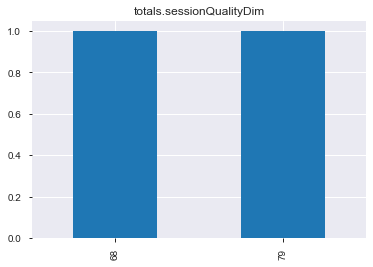

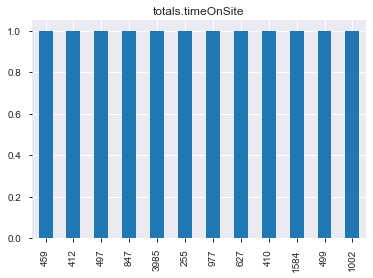

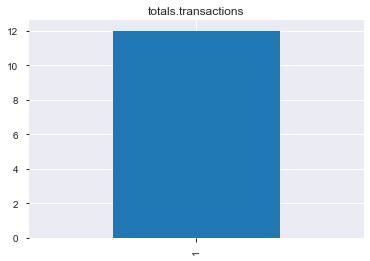

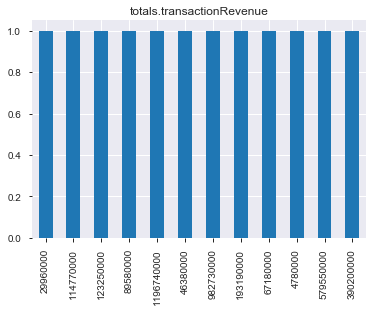

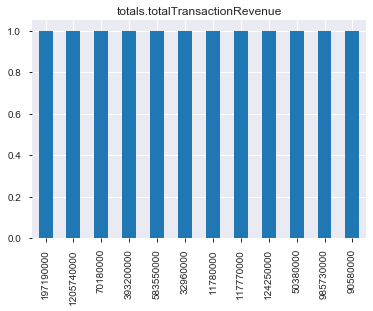

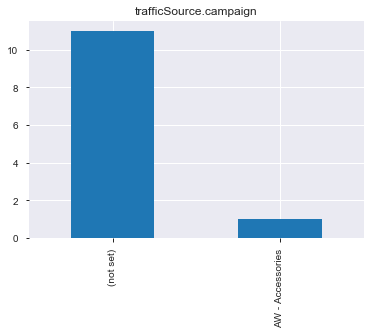

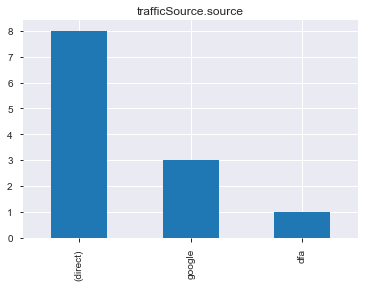

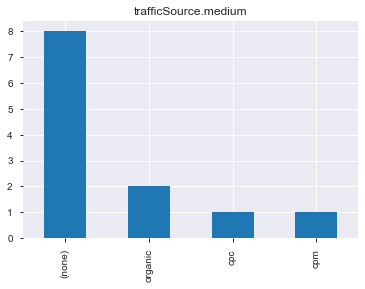

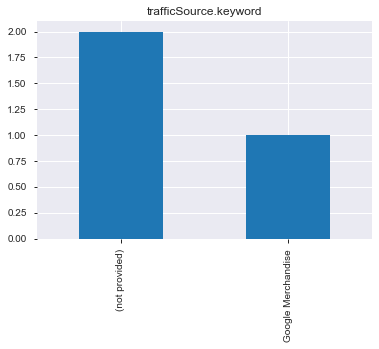

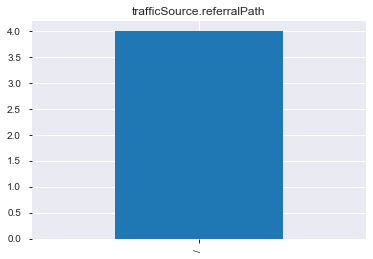

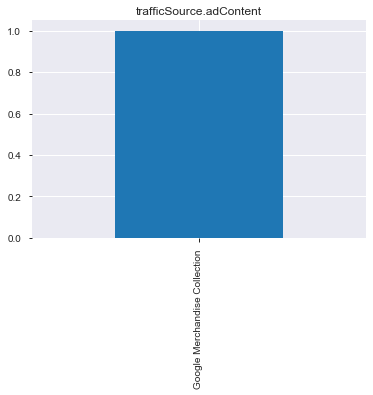

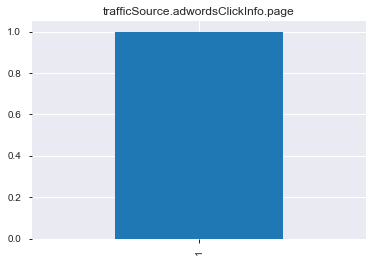

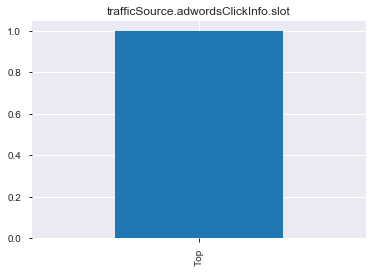

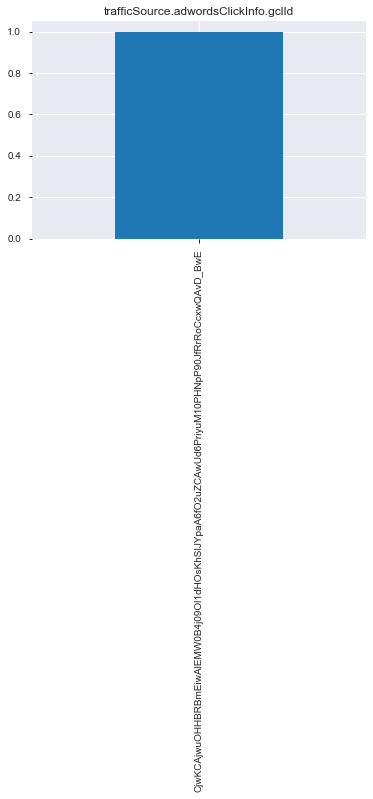

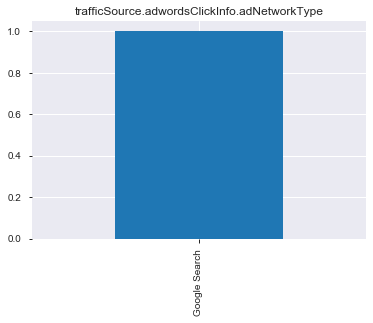

In [569]:
for column in list(period2_returnedCustomers.columns):
    plt.figure()
    period2_returnedCustomers[column].value_counts().plot(kind='bar', title=column)
    plt.show()